In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.svm import *
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
import numpy as np
import cv2
import glob
import os
import pickle
import time

%matplotlib inline

In [2]:
DATA_PATH = './data/'
VEHICLES_DATA_PATH = os.path.join(DATA_PATH, 'vehicles')
NON_VEHICLES_DATA_PATH = os.path.join(DATA_PATH, 'non-vehicles')
MODELS_PATH = './models'
TEST_PATH = './test_images'
PROJECT_VIDEO_PATH = './project_video.mp4'
CHALLENGE_VIDEO_PATH = './challenge_video.mp4'
HARDER_CHALLENGE_VIDEO_PATH = './harder_challenge_video.mp4'

In [3]:
vehicle_imgs_path = []
for d in os.listdir(VEHICLES_DATA_PATH):
    dir_path = os.path.join(VEHICLES_DATA_PATH, d)    
    vehicle_imgs_path.extend(glob.glob(os.path.join(dir_path, '*.png')))
    
non_vehicle_imgs_path = []
for d in os.listdir(NON_VEHICLES_DATA_PATH):
    dir_path = os.path.join(NON_VEHICLES_DATA_PATH, d)    
    non_vehicle_imgs_path.extend(glob.glob(os.path.join(dir_path, '*.png')))
    
print('{} vehicles in training set'.format(len(vehicle_imgs_path)))
print('{} non-vehicles in training set'.format(len(non_vehicle_imgs_path)))

8792 vehicles in training set
8968 non-vehicles in training set


In [13]:
# Load images
vehicle_imgs = []
for path in vehicle_imgs_path:
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    vehicle_imgs.append(img)

non_vehicle_imgs = []
for path in non_vehicle_imgs_path:
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    non_vehicle_imgs.append(img)

### Plot sample images

Vehicles


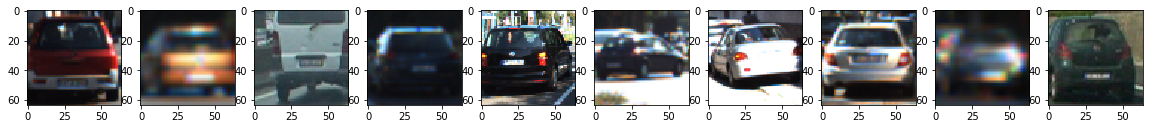

Non-vehicles


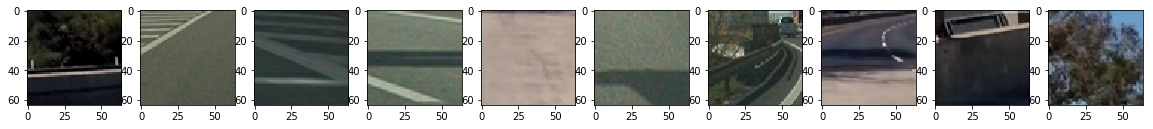

In [15]:
SAMPLE_SIZE = 10
vehicle_random_idxs = np.random.randint(0, high=len(vehicle_imgs)-1, size=SAMPLE_SIZE)
non_vehicle_random_idxs = np.random.randint(0, high=len(non_vehicle_imgs)-1, size=SAMPLE_SIZE)

print('Vehicles')
f, ax = plt.subplots(1, SAMPLE_SIZE, figsize=(20, 10*SAMPLE_SIZE))
for i, idx in enumerate(vehicle_random_idxs):
    img = vehicle_imgs[idx]
    ax[i].imshow(img)
plt.show()

print('Non-vehicles')
f, ax = plt.subplots(1, SAMPLE_SIZE, figsize=(20, 10*SAMPLE_SIZE))
for i, idx in enumerate(non_vehicle_random_idxs):
    img = non_vehicle_imgs[idx]
    ax[i].imshow(img)
plt.show()

In [190]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True, transform_sqrt=False):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=transform_sqrt, visualise=vis, 
                                  feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=transform_sqrt, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, params):
    color_space=hyperparams['color_space']
    spatial_size=hyperparams['spatial_size']
    hist_bins=hyperparams['hist_bins'] 
    orient=hyperparams['orient']
    pix_per_cell=hyperparams['pix_per_cell']
    cell_per_block=hyperparams['cell_per_block']
    hog_channel=hyperparams['hog_channel']
    spatial_feat=hyperparams['spatial_feat']
    hist_feat=hyperparams['hist_feat']
    hog_feat=hyperparams['hog_feat']
    
    features = []
    for image in imgs:
        file_features = []
        #image = cv2.imread(file)
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
                
        if spatial_feat == True:
            #t1 = time.time()
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            #t2 = time.time()
            #print("{} sec spatial bin".format((t2-t1)))
            file_features.append(spatial_features)
        if hist_feat == True:
            #t1 = time.time()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            #t2 = time.time()
            #print("{} sec color hist".format((t2-t1)))
            file_features.append(hist_features)
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                #t1 = time.time()
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                #t2 = time.time()
                #print("{} sec hog feat".format((t2-t1)))    
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    return features

### Train and save model

In [357]:
# Define hyperparams
hyperparams = {
    'color_space': 'LUV',       # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    'orient': 9,                # HOG orientations
    'pix_per_cell': 16,         # HOG pixels per cell
    'cell_per_block': 2,        # HOG cells per block
    'hog_channel': 'ALL',       # Can be 0, 1, 2, or "ALL"
    'spatial_size': (16, 16),   # Spatial binning dimensions
    'hist_bins': 16,            # Number of histogram bins
    'spatial_feat': True,       # Spatial features on or off
    'hist_feat': True,          # Histogram features on or off
    'hog_feat': True,           # HOG features on or off
    'min_samples_split': 5      # min_samples_split for boosting clf
}

In [316]:
vehicle_features = extract_features(vehicle_imgs, hyperparams)
non_vehicle_features = extract_features(non_vehicle_imgs, hyperparams)

print('Training on vehicle px in range {}-{}'.format(np.amin(np.array(vehicle_imgs)), 
                                                     np.amax(np.array(vehicle_imgs))))
print('Training on non-vehicle px in range {}-{}'.format(np.amin(np.array(non_vehicle_imgs)), 
                                                         np.amax(np.array(non_vehicle_imgs))))

X = np.vstack((vehicle_features, non_vehicle_features)).astype(np.float64)                        
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

y = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(non_vehicle_features))))

rand_state = np.random.randint(0, 100)
print('rand_state', rand_state)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print(hyperparams)
print('Feature vector length:', len(X_train[0]))
model_type = 'svc'
clf = SVC(C=1.0, kernel='linear', gamma='auto')
#clf = RandomForestClassifier()

# Training time
t1 = time.time()
clf.fit(X_train, y_train)
t2 = time.time()
print('{} seconds to train {}'.format(round(t2-t1, 2), model_type))
# Test accuracy
print('Test Accuracy of {} = {}'.format(model_type, round(clf.score(X_test, y_test), 4)))

# Save model and scaler
ts = int(time.time())
model_name = "{}-{}.pkl".format(model_type, ts)
scaler_name = "{}-scaler-{}.pkl".format(model_type, ts)
pickle.dump(clf, open(os.path.join(MODELS_PATH, model_name), "wb"))
pickle.dump(X_scaler, open(os.path.join(MODELS_PATH, scaler_name), "wb"))
print('Saved {} {}'.format(model_name, scaler_name))

Training on vehicle px in range 0-255
Training on non-vehicle px in range 0-255
rand_state 19
{'hist_bins': 64, 'hist_feat': True, 'spatial_feat': True, 'cell_per_block': 2, 'hog_channel': 'ALL', 'hog_feat': True, 'spatial_size': (64, 64), 'pix_per_cell': 16, 'min_samples_split': 5, 'color_space': 'LUV', 'orient': 9}
Feature vector length: 13452
244.24 seconds to train svc
Test Accuracy of svc = 0.9901
Saved svc-1513580728.pkl svc-scaler-1513580728.pkl


### Load model and scaler

In [358]:
ts = 1513456646
clf = pickle.load(open(os.path.join(MODELS_PATH, "{}-{}.pkl".format(model_type, ts)), "rb"))
X_scaler = pickle.load(open(os.path.join(MODELS_PATH, "{}-scaler-{}.pkl".format(model_type, ts)), "rb"))

In [326]:
def convert_color(image, color_space):
    if color_space == 'HSV':
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    elif color_space == 'LUV':
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
    elif color_space == 'HLS':
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    elif color_space == 'YUV':
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    elif color_space == 'YCrCb':
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else:
        feature_image = np.copy(image)
    return feature_image

def find_cars(img, ystart, ystop, scale, clf, X_scaler, color_space, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, spatial_feat=True,
              hist_feat=True, hog_feat=True, plot=False):
    if plot:
        draw_img = np.copy(img)
    
    img_tosearch = img[ystart:ystop,:,:]
    
    ctrans_tosearch = convert_color(img_tosearch, color_space=color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # Compute individual channel HOG features for the entire image
    #t1 = time.time()
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    #t2 = time.time()
    #print('{} sec hog features'.format(round(t2-t1, 2)))
    
    # Define blocks and steps as above
    nxblocks = hog1.shape[1]
    nyblocks = hog1.shape[0]
    nfeat_per_block = orient*cell_per_block*cell_per_block

    # 64px was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    px_per_step = cells_per_step * pix_per_cell
    
    nxsteps = (ch1.shape[1] - window) // px_per_step
    nysteps = (ch1.shape[0] - window) // px_per_step
    bboxes = []
    
    #print('ch1.shape', ch1.shape, 'px_per_step', px_per_step)
    #print('nxsteps', nxsteps, 'nysteps', nysteps)
    for xb in range(nxsteps):
        for yb in range(nysteps):
            features = []
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            if spatial_feat:
                spatial_features = bin_spatial(subimg, size=spatial_size)
                features.append(spatial_features)
            
            if hist_feat:
                hist_features = color_hist(subimg, nbins=hist_bins)
                features.append(hist_features)
            
            # Extract HOG for this patch
            if hog_feat:
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
                features.append(hog_features)
            
            features = np.concatenate(features, axis=0).reshape(1, -1)

            # Scale features and make a prediction
            test_features = X_scaler.transform(features)
            test_prediction = clf.predict(test_features)
            
            xbox_left = np.int(xleft*scale)
            ytop_draw = np.int(ytop*scale)
            win_draw = np.int(window*scale)
            bbox = ((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))
            if test_prediction == 1:
                bboxes.append(bbox)
            elif test_prediction == 0 and plot == True:
                cv2.rectangle(draw_img, bbox[0], bbox[1], (255, 0, 0), 2)
    if plot:
        for bbox in bboxes:
            cv2.rectangle(draw_img, bbox[0], bbox[1], (0, 255, 0), 6) 
        return bboxes, draw_img
    else:
        return bboxes

### Test on sample images

0.12 seconds processing time


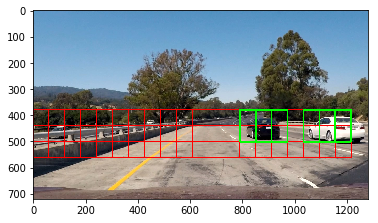

0.12 seconds processing time


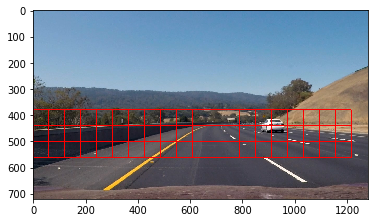

0.12 seconds processing time


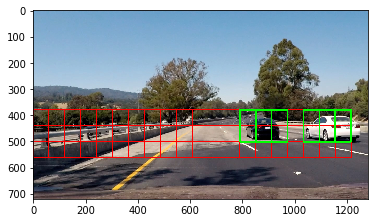

0.12 seconds processing time


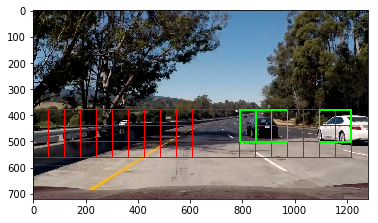

0.13 seconds processing time


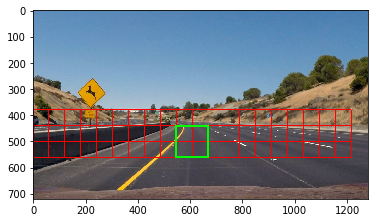

0.13 seconds processing time


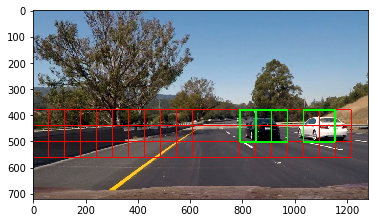

In [359]:
ystart = 380
ystop = 660
scale = 1.9

for img_path in glob.glob(os.path.join(TEST_PATH, '*.jpg')):
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    t1=time.time()
    _, out_img = find_cars(img, ystart, ystop, scale, clf, X_scaler, hyperparams['color_space'], 
                           hyperparams['orient'], hyperparams['pix_per_cell'], hyperparams['cell_per_block'], 
                           hyperparams['spatial_size'], hyperparams['hist_bins'], spatial_feat=hyperparams['spatial_feat'],
                           hist_feat=hyperparams['hist_feat'], plot=True)
    t2 = time.time()
    print('{} seconds processing time'.format(round(t2-t1, 2)))
    plt.imshow(out_img)
    plt.show()

In [384]:
class VehicleDetector():
    def __init__(self):
        self.MAX_WINDOW_SIZE = 15
        self.HEATMAP_THRESHOLD = 5
        self.HEAT = 1
        self.window = []
        self.REGIONS = [{'ystart': 380, 'ystop': 680, 'scale': 1.0}]

    def add_heat(self, heatmap, bbox_list):
        # Iterate through list of bboxes
        for box in bbox_list:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += self.HEAT

        # Return updated heatmap
        return heatmap

    def apply_threshold(self, heatmap, threshold):
        # Zero out pixels below the threshold
        heatmap[heatmap <= threshold] = 0
        # Return thresholded map
        return heatmap
    
    def draw_labeled_bboxes(self, img, labels):
        # Iterate through all detected cars
        for car_number in range(1, labels[1]+1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0, 0, 255), 6)
        # Return the image
        return img

    def filter_false_positives(self, img):
        bboxes = []
        for bboxs in self.window[-self.MAX_WINDOW_SIZE:]:
            bboxes.extend(bboxs)
        
        # Add heat to each box in box list
        heatmap = np.zeros_like(img[:, :, 0]).astype(np.float)
        heatmap = self.add_heat(heatmap, bboxes)

        # Apply threshold to help remove false positives
        heatmap = self.apply_threshold(heatmap, self.HEATMAP_THRESHOLD)

        # Visualize the heatmap when displaying    
        heatmap = np.clip(heatmap, 0, 255)
        
        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        draw_img = self.draw_labeled_bboxes(np.copy(img), labels)
    
        return draw_img

    def detect(self, img):
        for region in self.REGIONS:
            ystart = region['ystart']
            ystop = region['ystop']
            scale = region['scale']
            bboxes = find_cars(img, ystart, ystop, scale, clf, X_scaler, hyperparams['color_space'], 
                               hyperparams['orient'], hyperparams['pix_per_cell'], hyperparams['cell_per_block'], 
                               hyperparams['spatial_size'], hyperparams['hist_bins'], plot=False)
            self.window.append(bboxes)
        result_img = self.filter_false_positives(img)
        return result_img

In [385]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Run pipeline on project_video
vehicleDetector = VehicleDetector()
output = 'output_project_video_{}.mp4'.format(str(ts))
clip = VideoFileClip("project_video.mp4")
clip = clip.fl_image(vehicleDetector.detect)
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_project_video_1513456646.mp4
[MoviePy] Writing video output_project_video_1513456646.mp4



 12%|█▏        | 152/1261 [01:42<12:48,  1.44it/s]


 24%|██▍       | 303/1261 [03:26<10:46,  1.48it/s]


 36%|███▌      | 454/1261 [05:09<09:02,  1.49it/s]


 48%|████▊     | 605/1261 [06:52<07:30,  1.46it/s]


 60%|█████▉    | 756/1261 [08:36<05:46,  1.46it/s]


 72%|███████▏  | 907/1261 [10:19<04:02,  1.46it/s]


 84%|████████▍ | 1057/1261 [12:02<02:21,  1.44it/s]


 96%|█████████▌| 1205/1261 [13:43<00:37,  1.48it/s]


100%|█████████▉| 1260/1261 [14:21<00:00,  1.46it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_project_video_1513456646.mp4 

CPU times: user 14min 21s, sys: 2.52 s, total: 14min 23s
Wall time: 14min 22s


In [386]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

In [65]:
ts = 45.0
clip.save_frame(os.path.join('./test_images_2', 'project_video_t_{}s.jpg'.format(ts)), t=ts)

./test_images_2/project_video_t_1.5s.jpg
0.65 seconds processing time


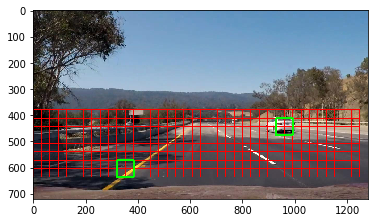

./test_images_2/project_video_t_10.0s.jpg
0.66 seconds processing time


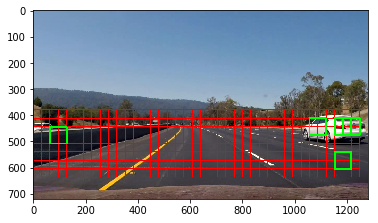

./test_images_2/project_video_t_12.0s.jpg
0.66 seconds processing time


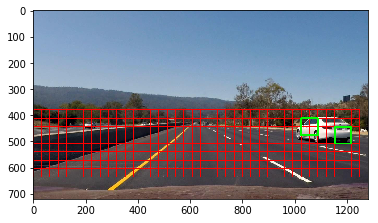

./test_images_2/project_video_t_14.0s.jpg
0.65 seconds processing time


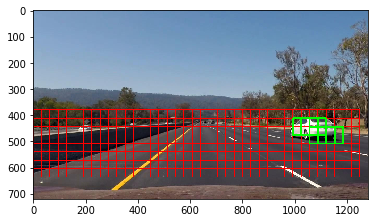

./test_images_2/project_video_t_16.0s.jpg
0.66 seconds processing time


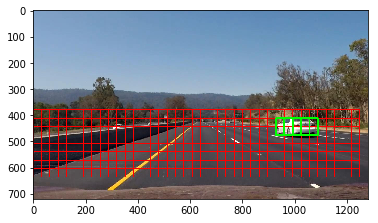

./test_images_2/project_video_t_1s.jpg
0.65 seconds processing time


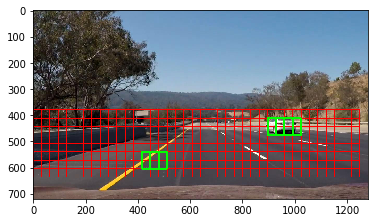

./test_images_2/project_video_t_2.5s.jpg
0.66 seconds processing time


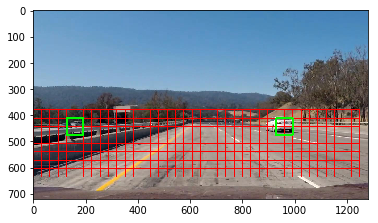

./test_images_2/project_video_t_21.0s.jpg
0.65 seconds processing time


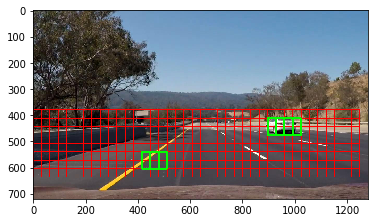

./test_images_2/project_video_t_25.0s.jpg
0.66 seconds processing time


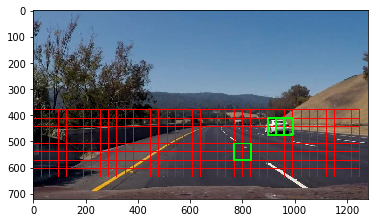

./test_images_2/project_video_t_27.0s.jpg
0.65 seconds processing time


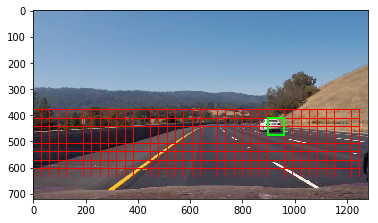

./test_images_2/project_video_t_2s.jpg
0.65 seconds processing time


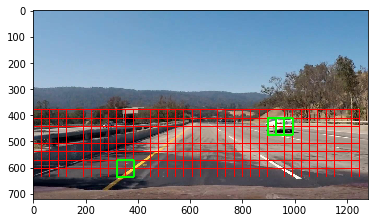

./test_images_2/project_video_t_3.5s.jpg
0.65 seconds processing time


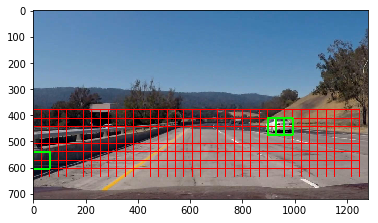

./test_images_2/project_video_t_30.0s.jpg
0.66 seconds processing time


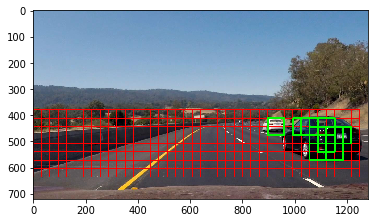

./test_images_2/project_video_t_34.0s.jpg
0.65 seconds processing time


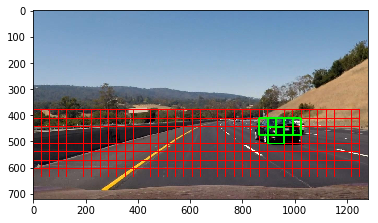

./test_images_2/project_video_t_36.0s.jpg
0.66 seconds processing time


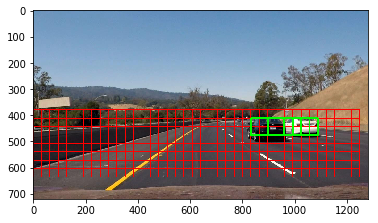

./test_images_2/project_video_t_3s.jpg
0.65 seconds processing time


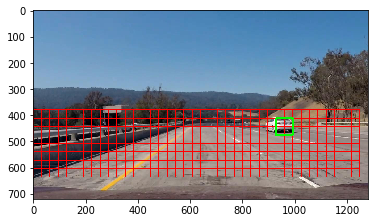

./test_images_2/project_video_t_45.0s.jpg
0.66 seconds processing time


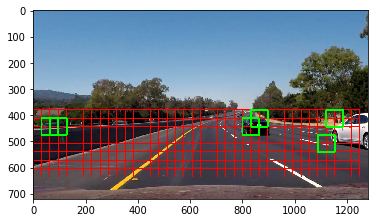

./test_images_2/project_video_t_7.0s.jpg
0.65 seconds processing time


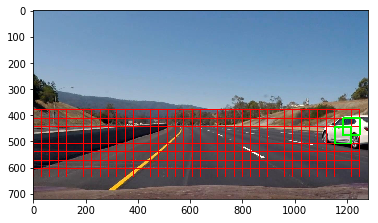

In [383]:
ystart = 380
ystop = 680
scale = 1.0

for img_path in sorted(glob.glob(os.path.join('./test_images_2', '*.jpg'))):
    print(img_path)
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    t1=time.time()
    _, out_img = find_cars(img, ystart, ystop, scale, clf, X_scaler, hyperparams['color_space'], 
                           hyperparams['orient'], hyperparams['pix_per_cell'], hyperparams['cell_per_block'], 
                           hyperparams['spatial_size'], hyperparams['hist_bins'], 
                           spatial_feat=hyperparams['spatial_feat'], hist_feat=hyperparams['hist_feat'], plot=True)
    t2 = time.time()
    print('{} seconds processing time'.format(round(t2-t1, 2)))
    plt.imshow(out_img)
    plt.show()